## Load dependencies and helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import deconvolve, fftconvolve
import ipywidgets as widgets

Sensor constants from experimental data:

1. For GCaMP6s and GCaMP6f _in vivo_ recordings in larval drosophila [in the paper describing GCaMP6 family of indicators; supplementary table 4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3777791/).
2. For H2B:GCaMP6s _in vivo_ recordings in zebrafish [in this paper; materials and methods: Estimation of the decay time constant of the nuclear H2B-GCaMP6s calcium sensor](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6288061/).

kernel for calcium indicator, [based on equation 1 of this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6288061/)

In [2]:
half_time_off = {
    "GCaMP6s": 1.14,
    "GCaMP6f": 0.38,
    "H2B:GCaMP6s": 2.8
}

time_constant_off = {k: half_time_off[k] / np.log(2) for k in half_time_off}

In [3]:
def magic_plot(x, y,  title=None, axes_off=True, figsize=(40, 2)):
    plt.figure(figsize=figsize)
    plt.plot(x, y)
    if title:
        plt.title(title, loc='left',y=0)
    if axes_off:
        plt.axis('off')

In [4]:
def poisson_process(stimulus, max_firing_rate=20):
    '''
    :param stimulus: 1D array with value of stimulus {0:1} at each time-point
    :param max_firing_rate: int, Hz
    returns: Spike train with probability=firing_rate for time=time
    '''
    dt = 1/1000  # seconds
    threshold = max_firing_rate * dt * stimulus
    spike_train =  np.random.random(len(stimulus)) > (1 - threshold)
    return spike_train.astype(int)

In [5]:
def binary_stimulus(start_times:np.ndarray, duration_epoch:int, experiment_duration:int):
    """
    A stimulus trace generator for a property that exists only in two states.
    
    :param start_times: 1D array with starting times (seconds) of each stimulus presentation
    :param duration_epoch: Duration of each presentation in seconds
    :param experiment_duration: Duration in seconds of the whole trace. Has to be longer than (start_times[-1] + experiment_duration)
    """
    if experiment_duration < start_times[-1] + duration_epoch:
        raise Exception("Last stimulus presentation happens outside experiment_duration")
        return
    dt = 1/1000  # seconds
    stimulus = np.zeros(int(experiment_duration / dt))
    start_times = start_times / dt
    start_times = start_times.astype(int)
    for start_time in start_times:     
        stimulus[start_time:int(start_time + duration_epoch / dt)] = 1
    return stimulus

In [6]:
def ramping_stimulus(start_times:np.ndarray, duration_epoch:int, experiment_duration:int):
    if experiment_duration < start_times[-1] + duration_epoch:
        raise Exception("Last stimulus presentation happens outside experiment_duration")
        return
    dt = 1/1000  # seconds
    stimulus = np.zeros(int(experiment_duration / dt))
    start_times = start_times / dt
    start_times = start_times.astype(int)
    ramp = np.linspace(0, 1, int(duration_epoch / dt))
    for start_time in start_times:     
        stimulus[start_time:int(start_time + duration_epoch / dt)] = ramp
    return stimulus

In [7]:
def exponential_kernel(t, tau=1, pad=True):
    """
    :param t: 1D array of time points
    :param tau: Time constant for exponential decay of the indicator
    :param pad: Whether to pad kernel at init with length = len(t)
    returns: A kernel or generative decaying exponenial function
    """
    hemi_kernel = 1/tau * np.exp(-t/tau)
    if pad:
        len_pad = len(hemi_kernel)
        hemi_kernel = np.pad(hemi_kernel,(len_pad,0))
    return hemi_kernel

In [19]:
wid_indicator = widgets.Dropdown(
    options=[k for k in half_time_off],
    value='GCaMP6s',
    description='GECI:',
    disabled=False,
)

wid_sample_rate = widgets.IntSlider(
    value=3,
    min=1,
    max=30.0,
    step=1,
    description='Sampling Hz:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

wid_firing_rate = widgets.IntSlider(
    value=10,
    min=1,
    max=40.0,
    step=1,
    description='Firing Hz:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

wid_spontaneous_firing_rate = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=2.0,
    step=0.01,
    description='Basal Hz:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.2f',
)

wid_experiment_duration = widgets.IntSlider(
    value=30,
    min=5,
    max=200,
    step=1,
    description='Experiment (s):',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

wid_stim_duration = widgets.FloatSlider(
    value=2.0,
    min=0.1,
    max=5.0,
    step=0.1,
    description='Stimulus (s):',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

wid_signal_noise_ratio = widgets.FloatSlider(
    value=5.0,
    min=1.0,
    max=20.0,
    step=0.5,
    description='SNR:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

wid_start_times = widgets.SelectMultiple(
    options = list(np.arange(0,200,1)),
    rows=10,
    description='Stim start (s)',
    disabled=False,
    value=(5, 10, 15, 20)
)

wid_stim_type = widgets.Dropdown(
    options=['Binary', 'Ramping'],
    value='Binary',
    description='Stimulus:',
    disabled=False,
)


def wid_bridge(a, b, c, d, e, f, g, h, i):
    global indicator
    indicator = b
    global sample_rate
    sample_rate = a
    global firing_rate
    firing_rate = c
    global spontaneous_firing_rate
    spontaneous_firing_rate = d
    global experiment_duration
    experiment_duration = e
    global stim_duration
    stim_duration = f
    global signal_noise_ratio
    signal_noise_ratio = g
    global stim_start_times
    stim_start_times = h
    global stim_type
    stim_type = i

## Design your experment

In [20]:
widgets.interactive_output(wid_bridge, {'a': wid_sample_rate, 'b': wid_indicator, 'c': wid_firing_rate, 'd': wid_spontaneous_firing_rate, 'e': wid_experiment_duration, 'f': wid_stim_duration, 'g': wid_signal_noise_ratio, 'h': wid_start_times, 'i': wid_stim_type})
widgets.HBox([wid_indicator, wid_sample_rate, wid_firing_rate, wid_spontaneous_firing_rate, wid_experiment_duration, wid_stim_duration, wid_signal_noise_ratio, wid_start_times, wid_stim_type])

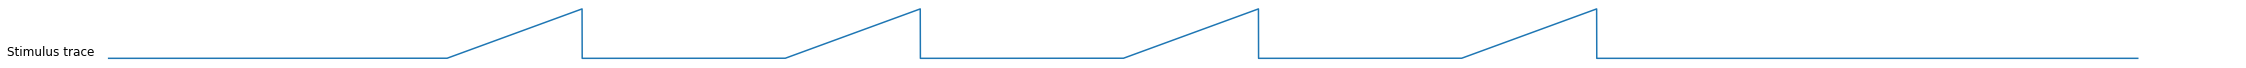

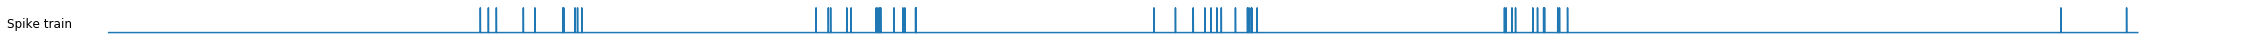

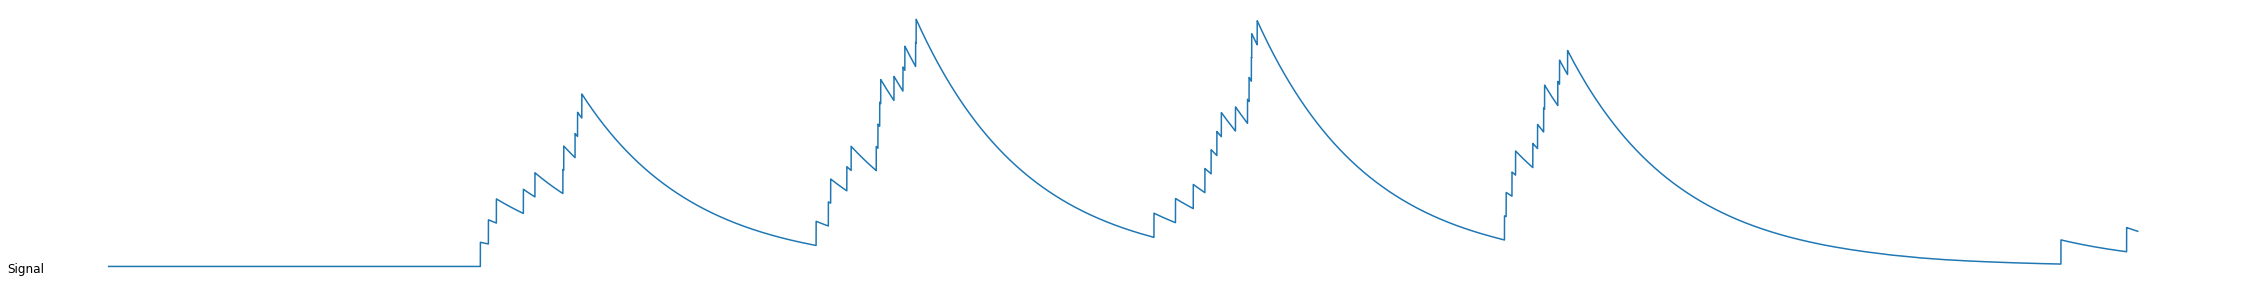

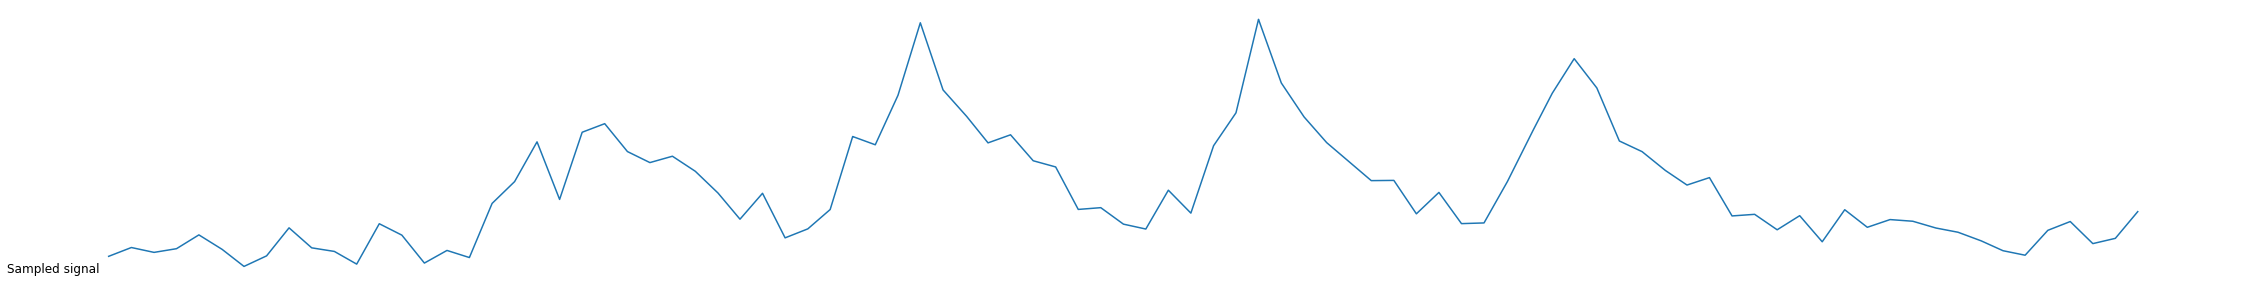

In [18]:
time_constant = time_constant_off[indicator]  # seconds
len_kernel = time_constant * 6  # seconds. Should be long enough to almost reach zero 

xca = np.arange(0, len_kernel, 0.001)
calcium_kernel = exponential_kernel(xca, tau=time_constant_off[indicator])

# aux_xca = np.arange(0, len(calcium_kernel) / 1000, 0.001)

# magic_plot(aux_xca, calcium_kernel, figsize=(10,3))
# print(calcium_kernel[-1])

stim_start_times = np.array(stim_start_times)
if stim_type == "Binary":
    stimulus = binary_stimulus(stim_start_times, stim_duration, experiment_duration)
if stim_type == "Ramping":
    stimulus = ramping_stimulus(stim_start_times, stim_duration, experiment_duration)

xt = np.arange(0, experiment_duration, .001)
magic_plot(xt, stimulus, "Stimulus trace", figsize=(40,1))

spontaneous_spikes = poisson_process(np.ones(len(stimulus)),spontaneous_firing_rate)
spikes = poisson_process(stimulus,firing_rate)
spikes = np.ceil(spikes + spontaneous_spikes)

magic_plot(xt, spikes, "Spike train", figsize=(40,0.5))

conv_signal = np.convolve(spikes, calcium_kernel, mode='same')

magic_plot(xt, conv_signal, "Signal", figsize=(40,5))

period = int(1000/sample_rate)

sampled_signal = conv_signal[0::period]
noise = np.max(sampled_signal) * (np.random.rand(len(sampled_signal)) / signal_noise_ratio)  # we add some noise to account for real experimental conditions
sampled_signal = sampled_signal + noise
x = np.linspace(0, experiment_duration, len(sampled_signal))

sampled_signal_interpolated = np.interp(xt, x, sampled_signal)

magic_plot(xt, sampled_signal_interpolated, "Sampled signal", figsize=(40,5))